# Контент из кассандры. Сбор сбалансированной выборки. Классификатор

## Джоин доменов с кассандрой. Запись данных в parquet

In [ ]:
# !pip install cassandra-driver

In [1]:
from pyspark.sql.types import StructField, StructType, StringType, ArrayType, DoubleType, FloatType, IntegerType
from pyspark.sql import SQLContext
import pyspark_cassandra
import cassandra
from cassandra.cluster import Cluster
import hdfs

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import nltk
import pickle
import pandas as pd
import numpy as np
import re

In [43]:
myshema = StructType([StructField("domain", StringType()), StructField("content", StringType())])
DOMAIN_TEXT_MAX_LENGHT = 5 * 2 ** 20 #5Mb is enough

def trim(text):
    return text[:DOMAIN_TEXT_MAX_LENGHT]
def clean(df, column='content'):
    X = df[column]
    X = X.apply(lambda x: x.lower()) #переводим весь текст в нижний регистр
    X = X.apply(lambda r: re.sub('[^a-zA-ZáéíñóúüÁÉÍÑÓÚÜ]', ' ', r))
    X = X.apply((lambda x: re.sub(r'\b\w{,1}\b', ' ', x))) #удаляем все тройные буквы
    X = X.apply((lambda x: re.sub(r'\s+', ' ', x))) #убираем пачки последовательных пробелов
    df[column] = X
    
DOMAIN_TEXT_MIN_LENGHT = 200
DOMAIN_CLASS = 42
PATH = 'politic_lab.csv'
col_type = 1 # 0 if domain only, 1 if domain + lab
clean_file = True
usecols = ['domain'] if col_type == 0 else ['domain', 'lab']
file = pd.read_csv(PATH, sep='\t', usecols=usecols)
file.drop_duplicates('domain', inplace=True)
file.lab = file.lab.astype(int)
file.loc[file.lab==1, 'lab'] = DOMAIN_CLASS
print(file.lab.value_counts())
print(file.shape)
cass_content = (sc.parallelize(file['domain'])
                    .map(lambda x: {"domain": x})
                    .joinWithCassandraTable("urls", "content").on("domain") 
                    .map(lambda r: {"domain": r[1]["domain"],
                                    "content": r[1]["document"].get("content", u""),
                         }) 
                    .filter(lambda r: len(r["content"].split(' ')) > DOMAIN_TEXT_MIN_LENGHT)
                    .map(lambda x: (x["domain"], {"content": x["content"]}))
                    .reduceByKey(lambda l, r: {"content": trim(l["content"]) + " " + trim(r["content"])})
                    .map(lambda x: {"domain": x[0], "content": x[1]["content"]})
                    )
sparkDf = spark.createDataFrame(cass_content, myshema)
pandDf = sparkDf.toPandas()
print(pandDf.shape)
if col_type != 0:
    pandDf = file.merge(pandDf, on='domain')
print(pandDf.shape)
if clean_file: clean(pandDf)
df = pd.DataFrame()
df['lab'] = pandDf['lab']
df['domain'] = pandDf['domain']
df['content'] = pandDf['content']
del pandDf
myshema = StructType([StructField("lab", StringType()), \
                      StructField("domain", StringType()), \
                      StructField("content", StringType())])
partitionNum = 100 # Increase this number if necessary
ds = sqlContext.createDataFrame(df, myshema).repartition(partitionNum)
name = 'content_politica'
parquet_path = "hdfs://e1.getaura.ru/spark-common/vectors/{}.parquet".format(name)
ds.write.parquet(parquet_path, mode='overwrite')
"/spark-common/vectors/{}.parquet".format(name)

42    928
0     472
38     98
3       1
Name: lab, dtype: int64
(1499, 2)
(1448, 2)
(1448, 3)


'/spark-common/vectors/content_politica.parquet'

## Считываем parquet файл с данными и собираем отрицательный контент

In [3]:
# Функция собирает из всех переданных файлов векторов отрицательный класс
def collector(df, drop_df, hdfs_path, paths, numbs, neg_cats, numb_class):
    df['lab'] = df['lab'].astype(int)
    df = df.sort_values('lab')
    f = df.loc[df['lab']==0]
    drop_indices = np.random.choice(f.index, drop_df, replace=False)
    df = df.drop(drop_indices)
    df.loc[df.lab!=numb_class, 'lab'] = 0
    print(df['lab'].value_counts())
    print(paths, numbs)
    for p, n, cat in zip(paths, numbs, neg_cats):
        print(p)
        cr = SQLContext(sc).read.parquet(hdfs_path.format(p))
        d = cr.toPandas()
        print(len(d))
        if 'lab' not in d.columns: d['lab'] = cat
        print(d['lab'].value_counts())
        try:
            d['lab'] = d['lab'].astype(int)
        except:
            d.drop(d.loc[~d.lab.isin([i for i in range(-1, 70)]+[str(i) for i in range(-1, 70)])].index, inplace=True)
            d['lab'] = d['lab'].astype(int)
        d = d.sort_values('lab')
        if len(d[d['lab']==0]) != 0:
            d = d.drop(d[d['lab']==0].index)
        print(d['lab'].value_counts())
        d.loc[d.lab != numb_class, 'lab'] = 0
        remove_n = 0 if len(d.loc[d.lab == 0]) - n < 0 else int(len(d.loc[d.lab == 0]) - n)
        drop_indices = np.random.choice(d.loc[d.lab == 0].index, remove_n, replace=False)
        d = d.drop(drop_indices)
        
        df = pd.concat([df, d], ignore_index=True)
        print(len(df))
        print(df['lab'].value_counts())
    df = df.sort_values('lab')
    return df

In [149]:
numb_target_class = 47
need_change_target_class = 1
hdfs_path = "hdfs://e1.getaura.ru/spark-common/vectors/{}.parquet"
neg_paths = ['esp_alco_tobacco_only_vectors',
'esp_drugs_vectors',
'vec_esp_turism',
'vectors_esp_astrology',
'vectors_esp_med',
'esp_adult_vectors',
'esp_films_vectors',
'esp_finances_vectors',
'esp_music_vectors',
'esp_porn_vectors',
'vectors_politica'
]
neg_cats = [14, 6, 52, 17, 39, 13, 22, 37, 23, 16, 42]
pos_paths = ['vectors_religion']
pos_data = pd.DataFrame()
for pos in pos_paths:
    pos_data_i = SQLContext(sc).read.parquet(hdfs_path.format(pos))
    pos_data_i = pos_data_i.toPandas()
    pos_data = pd.concat([pos_data, pos_data_i], axis=0)
pos_data.lab = pos_data.lab.astype(int)
pos_data.drop(pos_data[pos_data.domain.isin(to_drop)].index, inplace=True)
print(pos_data.head())
if need_change_target_class != 0:
    pos_data.loc[pos_data.lab == need_change_target_class, 'lab'] = numb_target_class
print(pos_data.head())
numb_negative_in_pos_data = pos_data.lab.value_counts().loc[0]
need_negative = (pos_data.shape[0] - numb_negative_in_pos_data) * 1
# need_negative_list = [int(need_negative/len(neg_paths)) for _ in neg_paths]
need_negative_list = [200, 100, 150, 250, 200, 150, 100, 100, 150, 150, 150]
drop_row_from_pos_data = 0 if numb_negative_in_pos_data <= need_negative / 2 \
                            else int(numb_negative_in_pos_data - need_negative / 2)
print(pos_data.shape, numb_negative_in_pos_data, need_negative, drop_row_from_pos_data)
balanced_data = collector(pos_data,
                          drop_row_from_pos_data,
                          hdfs_path,
                          neg_paths,
                          need_negative_list,
                          neg_cats,
                          numb_target_class)

   lab                    domain  \
0    0       santiagobovisio.com   
1    0                    dw.com   
2    1  virgendeguadalupe.org.mx   
3    1             egreenway.com   
4    1              earlysda.com   

                                              tokens  \
0  [santiag, bovisi, present, edicion, canon, ens...   
1  [dw, com, inhalt, navigation, weiter, inhalt, ...   
2  [insign, nacional, basil, sant, mar, guadalup,...   
3  [gre, way, research, michael, garofal, vancouv...   
4  [the, great, controversy, early, sda, sit, upd...   

                                          lda_vector  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                          lsi_vector fast_text_vector error  
0  [0.13460645079612732, -0.020

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



4437
0     3664
6      451
39     114
66     105
13      64
14      12
50       9
17       6
44       5
47       4
42       1
32       1
16       1
Name: lab, dtype: int64
6     451
39    114
66    105
13     64
14     12
50      9
17      6
44      5
47      4
42      1
32      1
16      1
Name: lab, dtype: int64
1706
47    1050
0      656
Name: lab, dtype: int64
vec_esp_turism
1906
0    1085
1     821
Name: lab, dtype: int64
1    821
Name: lab, dtype: int64
1856
47    1050
0      806
Name: lab, dtype: int64
vectors_esp_astrology
507
17    507
Name: lab, dtype: int64
17    507
Name: lab, dtype: int64
2106
0     1056
47    1050
Name: lab, dtype: int64
vectors_esp_med
2597
39    2597
Name: lab, dtype: int64
39    2597
Name: lab, dtype: int64
2306
0     1256
47    1050
Name: lab, dtype: int64
esp_adult_vectors
493
13    493
Name: lab, dtype: int64
13    493
Name: lab, dtype: int64
2456
0     1406
47    1050
Name: lab, dtype: int64
esp_films_vectors
666
22    666
Name: lab, dtype: int64
2

In [294]:
balanced_data.lab.value_counts()

0     7057
47    1542
Name: lab, dtype: int64

Пишем набор данных на локаль или hdfs

In [418]:
write_type = 'loc' # loc | hdfs | both
partitionNum = 10000 # Increase this number if necessary
myshema_to_write = StructType([
                                StructField("lab", IntegerType()),
                                StructField("domain", StringType()),
                                StructField("tokens", ArrayType(StringType())),
                                StructField("lda_vector", ArrayType(DoubleType())),
                                StructField("lsi_vector", ArrayType(DoubleType())),
])
balanced_data = balanced_data[['lab', 'domain','tokens', 'lda_vector', 'lsi_vector']]
if write_type == 'loc':
    balanced_data.to_pickle('47_religion_balanced.pkl')
elif write_type == 'hdfs':
    ds = sqlContext.createDataFrame(balanced_data, myshema_to_write).repartition(partitionNum)
    ds.write.parquet("hdfs://e1.getaura.ru/spark-common/vectors/vectors_politic_balanced.parquet",\
                          mode='overwrite')
else:
    balanced_data.to_pickle('43_politica_balanced.pkl')
    ds = sqlContext.createDataFrame(balanced_data, myshema_to_write).repartition(partitionNum)
    ds.write.parquet("hdfs://e1.getaura.ru/spark-common/vectors/vectors_politic_balanced.parquet",\
                          mode='overwrite')

## Делаем классификатор 

### Если нужно читаем уже готовый файл из parquet или pickle

In [2]:
read_mode = 'hdfs' # hdfs loc
hdfs_path = "hdfs://e1.getaura.ru/spark-common/vectors/{}.parquet"
if read_mode == 'loc':
    balanced_data = pd.read_pickle('47_religion_balanced.pkl')
else:
    balanced_data = SQLContext(sc).read.parquet(hdfs_path.format('vectors_politica'))

### Собираем вектора смотрим их распределение в пространстве

In [407]:
lda_vec_, lsi_vec_, y_ = balanced_data['lda_vector'], balanced_data['lsi_vector'], \
                         balanced_data['lab'].apply(int).tolist()
print(len(lda_vec_), len(lsi_vec_))
all_vec = np.array(list(lda_vec_ + lsi_vec_))
lda_vec = np.array(list(lda_vec_))
lsi_vec = np.array(list(lsi_vec_))
lab = y_
print(len(all_vec[0]), len(lda_vec[0]), len(lsi_vec[0]))

8146 8146
800 400 400


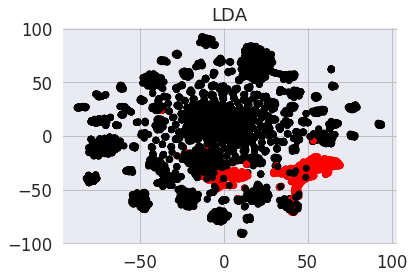

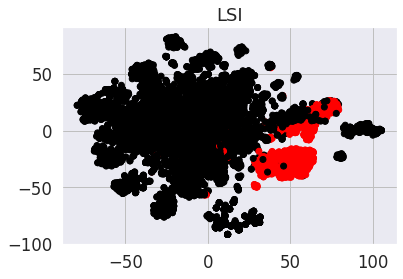

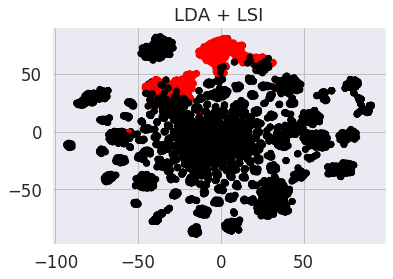

In [417]:
s1 = TSNE(n_components=2).fit_transform(lda_vec)
s2 = TSNE(n_components=2).fit_transform(lsi_vec)
s = TSNE(n_components=2).fit_transform(all_vec)

cluster_colors = {0: 'black', 47: 'red', 2: 'green', 3: 'blue',}#  3: 'pink', 4: 'grey', 5: 'yellow', 6: 'orange', 7: 'brown',
                  #8: 'silver', 9: 'lime', 10:'navy', 11:'salmon', 12:'cyan', 13:'tan', 14:'olive'}
cluster_names = {0:'0',43:'law',47:'religion',2:'astrology',3:'dating'}
%matplotlib inline

def make_pic(c, df, name_vectors, column='lab'):
    x, y = c[:,0 ], c[:,1]
    plt.scatter(x, y,
                color=df[column].map(cluster_colors), marker='o')
    plt.title(name_vectors)
    plt.grid(True, linestyle='-', color='0.75')
    plt.show()
    
for i, vec in zip([s1,s2,s], ['LDA', 'LSI', 'LDA + LSI']):
    make_pic(i, balanced_data, vec) 

## Пробуем различные модельки на разных векторах и обучаем лучшую модель

In [408]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import seaborn as sns

In [409]:
def pred(x_train, x_test, y_train, y_test, mod='LDA_VEC', verbose=False):
    roc_auc_list = []
    classifer_list = []
    classifer_names = ['RandomForest', 'DecisionTree', 'LogisticRegression', 'neighbors', 'GaussianNB', 'Linear SVM']
    
    rf = RandomForestClassifier(criterion='entropy', max_depth=25, min_samples_leaf=5, min_samples_split=2,
                                n_estimators=400, verbose=1, random_state = 42, n_jobs=12, class_weight='balanced')
    classifer_list.append(rf)
    rf.fit(x_train,y_train)
    predict = rf.predict(x_test)
    roc_auc_list.append(metrics.roc_auc_score(y_test, predict))
    if verbose:
        print(mod, ' - ',"RandomForestClassifier")
        print(metrics.classification_report(y_test, predict))
        print(metrics.confusion_matrix(y_test, predict))
    
    
    clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=25)
    classifer_list.append(clf_tree)
    clf_tree.fit(x_train,y_train)
    predict = clf_tree.predict(x_test)
    roc_auc_list.append(metrics.roc_auc_score(y_test, predict))
    if verbose:
        print(mod, ' - ',"DecisionTreeClassifier")
        print(metrics.classification_report(y_test, predict))
        print(metrics.confusion_matrix(y_test, predict))

    clf_log = LogisticRegression(solver='lbfgs')
    classifer_list.append(clf_log)
    clf_log.fit(x_train,y_train)
    predict = clf_log.predict(x_test)
    roc_auc_list.append(metrics.roc_auc_score(y_test, predict))
    if verbose:
        print(mod, ' - ',"LogisticRegression")
        print(metrics.classification_report(y_test, predict))
        print(metrics.confusion_matrix(y_test, predict))

    clf_knn = neighbors.KNeighborsClassifier(n_neighbors=7  ) #от 7 до 17
    classifer_list.append(clf_knn)
    clf_knn.fit(x_train,y_train)
    predict = clf_knn.predict(x_test)
    roc_auc_list.append(metrics.roc_auc_score(y_test, predict))
    if verbose:
        print(mod, ' - ',"neighbors")
        print(metrics.classification_report(y_test, predict))
        print(metrics.confusion_matrix(y_test, predict))

    clf_NB = GaussianNB()
    classifer_list.append(clf_NB)
    clf_NB.fit(x_train,y_train)
    predict = clf_NB.predict(x_test)
    roc_auc_list.append(metrics.roc_auc_score(y_test, predict))
    if verbose:
        print(mod, ' - ',"GaussianNB")
        print(metrics.classification_report(y_test, predict))
        print(metrics.confusion_matrix(y_test, predict))
    
    clf_svm = SVC(kernel='linear', probability=True, class_weight='balanced')
    classifer_list.append(clf_svm)
    clf_svm.fit(x_train,y_train)
    predict = clf_svm.predict(x_test)
    roc_auc_list.append(metrics.roc_auc_score(y_test, predict))
#     sns.set(font_scale=1.5)
#     sns.set_color_codes("muted")

#     plt.figure(figsize=(10, 8))
#     fpr, tpr, thresholds = metrics.roc_curve(y_test, clf_svm.predict_proba(x_test)[:,1], pos_label=43)
    
#     lw = 2
#     plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
#     plt.plot([0, 1], [0, 1])
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC curve')
#     plt.savefig("ROC.png")
#     plt.show()
    if verbose:
        print(mod, ' - ',"Linear SVM")
        print(metrics.classification_report(y_test, predict))
        print(metrics.confusion_matrix(y_test, predict))
    
    plt.plot(roc_auc_list, classifer_names, marker='o')
    plt.title(mod)
    plt.grid(True, linestyle='-', color='0.75')
    plt.show()
    return np.max(roc_auc_list), classifer_list[np.argmax(roc_auc_list)]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    1.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.1s finished


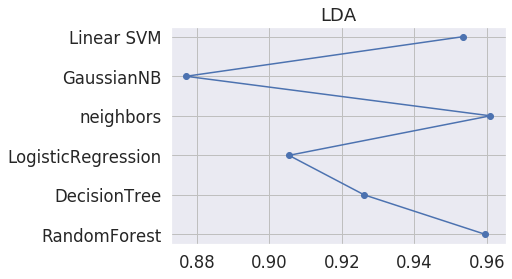

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    4.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.1s finished


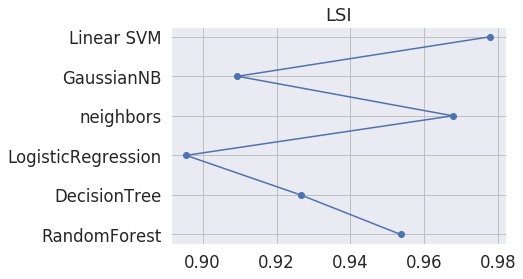

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    3.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.1s finished


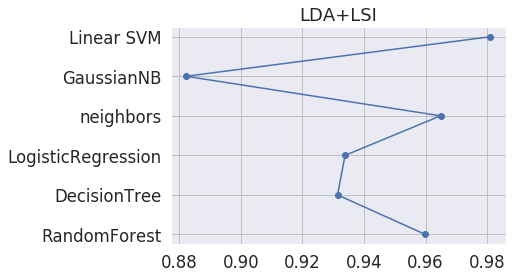

[0.9610036557454579, 0.9778842934124089, 0.9810688308863887]
Best roc_auc:  0.9810688308863887
Best clf:  SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Best vectors:  LDA+LSI


In [410]:
name_clf_to_save = '47_religion'
name_vec = ['LDA', 'LSI', 'LDA+LSI']
vecs = [lda_vec, lsi_vec, all_vec]
best_clfs = []
best_roc_aucs = []
with_detailed_print = False
for mode, vec in zip(name_vec, vecs):
    x_train, x_test, y_train, y_test = train_test_split(vec, lab, test_size=0.2, random_state=42)
    best_roc_auc, best_clf = pred(x_train, x_test, y_train, y_test, mode, with_detailed_print)
    best_clfs.append(best_clf)
    best_roc_aucs.append(best_roc_auc)
ind_best_roc_auc = np.argmax(best_roc_aucs)
print(best_roc_aucs)
print('Best roc_auc: ', best_roc_aucs[ind_best_roc_auc])
clf = best_clfs[ind_best_roc_auc]
print('Best clf: ', clf)
best_vec = vecs[ind_best_roc_auc]
print('Best vectors: ', name_vec[ind_best_roc_auc])
clf.fit(best_vec, lab)
with open('{}.pickle'.format(name_clf_to_save), 'wb') as handle:
    pickle.dump(clf, handle, protocol=2, )

## Тестируем

In [424]:
coef = clf.coef_.ravel()
# print(sorted(coef))
top_pos = np.argsort(coef)[-10:]
top_pos

array([404, 236, 418, 143, 437, 228, 423, 416,  12, 179])

In [240]:
name_clf_to_save = '47_religion'
with open('{}.pickle'.format(name_clf_to_save), 'rb') as handle:
    clf = pickle.load(handle)

In [412]:
def check_clf(clf, df=None, path=None, vec='all', num_class=47):
    if df is None:
        hdfs_path = 'hdfs://e1.getaura.ru/spark-common/vectors/{}.parquet'
        error = SQLContext(sc).read.parquet(hdfs_path.format(path))
        error = error.toPandas()
    else:
        error = df.copy()
    lda_vec_, lsi_vec_, y_ = error['lda_vector'], error['lsi_vector'], \
                             error['lab'].apply(int).tolist()
    if vec == 'all':
        vec = np.array(list(lda_vec_ + lsi_vec_))
    elif vec == 'lda':
        lda_vec = np.array(list(lda_vec_))
    else:
        lsi_vec = np.array(list(lsi_vec_))
    lab = y_
    error['predict'] = clf.predict(vec)
    return error[(error.lab==47) & (error.predict==0)].domain.values

In [413]:
check_clf(clf, balanced_data)

array([], dtype=object)

In [414]:
hdfs_path = 'hdfs://e1.getaura.ru/spark-common/vectors/{}.parquet'
test_data = SQLContext(sc).read.parquet(hdfs_path.format('spanish_test_vectors')) # 'esp_dom_vectors/10_day_of_mounth_domains_v'
test_data = test_data.repartition(1000)
name_positive_class = 'religion'

myshema_test = StructType([
                        StructField("domain", StringType()),
                        StructField("tokens", ArrayType(StringType())),
                        StructField(name_positive_class, FloatType()),
                     ])


In [278]:
# # Тянем из теста по условию
# myshema_to_write = StructType([
#                                 StructField("lab", IntegerType()),
#                                 StructField("domain", StringType()),
#                                 StructField("tokens", ArrayType(StringType())),
#                                 StructField("lda_vector", ArrayType(DoubleType())),
#                                 StructField("lsi_vector", ArrayType(DoubleType())),
# ])
# result = test_data.rdd.filter(lambda r: r.domain in lab_0)\
#                     .map(lambda r: {'domain':r.domain, 'tokens':r.tokens, 'lab':0, 'lda_vector':r.lda_vector, 'lsi_vector':r.lsi_vector})
# df = result.toDF(myshema_to_write).toPandas()

In [415]:
result = test_data.rdd.map(lambda r: {
                "domain": r.domain,
                "tokens": r.tokens[:100],
                name_positive_class: float(clf.predict_proba([r.lda_vector + r.lsi_vector])[0][1]),
                })\
                .filter(lambda r: (r[name_positive_class]>0.5))

In [416]:
df = result.toDF(myshema_test).toPandas()
df.tokens = df.tokens.apply(lambda r: ' '.join(r))
df.drop_duplicates('domain', inplace=True)
df = df.sort_values(name_positive_class, ascending=False)
df.to_csv('{}_proba.csv'.format(name_positive_class), sep='\t', index=False)

In [420]:
dd = df[df.religion>0.79][['domain', 'religion']].copy()
dd.religion = 47
dd.head()

,domain,religion
5861,cfcelbuenpastor.org,47
10201,01800iglesia.org,47
7280,catequesisactual.com,47
7319,buscadyhallareis.com,47
2257,devociones.org,47


In [421]:
dd.to_csv('47_religion_w_50.csv', sep='\t', index=False, header=False)

## Создаем таблицу для результатов классификации

In [428]:
lang = 'esp'
name_class = 'religion'
binary = True
cluster = Cluster(["88.198.45.102", "88.198.45.103", "88.198.45.104", "88.198.45.105", "88.198.45.106"])
session = cluster.connect('build')
if binary:
    session.execute("""CREATE TABLE {}_{} (
                             domain text PRIMARY KEY,
                             p float,
                             tag text,
                             ts timestamp,
                             cat int,
                             ) ;""".format(lang, name_class))
else:
    session.execute("""CREATE TABLE {}_{} (
                         domain text PRIMARY KEY,
                         cats map<int, float>,
                         tag text,
                         ts timestamp
                        ) ;""".format(lang, name_class))

## Создаем папку для модели классификатора и грузим на hdfs

In [429]:
# !pip install hdfs
lang = 'esp'
name_class = 'religion'
name_clf_to_upload = '47_religion'
dir_for_this_model = '{}_{}/'.format(lang, name_class)
dir_for_models = "/spark-common/classifiers/"
hdfs_path = dir_for_models + dir_for_this_model

hdfs_url ='http://e1.getaura.ru:50070'
cli = hdfs.InsecureClient(hdfs_url)
cli.makedirs(hdfs_path)
try:
    cli.upload(hdfs_path, os.path.join(os.getcwd(),
                                       '{}.pickle'.format(name_clf_to_upload)),
               n_threads=-1, chunk_size=100, cleanup=True)
except:
    cli.delete(os.path.join(hdfs_path ,'{}.pickle'.format(name_clf_to_upload)))
    cli.upload(hdfs_path, os.path.join(os.getcwd(),
                                       '{}.pickle'.format(name_clf_to_upload)),
               n_threads=-1, chunk_size=100, cleanup=True)

## Собираем все переданные вектора в один файл

In [35]:
# Функция собирает из всех переданных файлов 
def all_vecs_to_one_parquet(hdfs_path, paths, cats):
    df_pos = pd.DataFrame()
    df_neg = pd.DataFrame()
    for path, cat in zip(paths, cats):
        print(path)
        cr = SQLContext(sc).read.parquet(hdfs_path.format(path))
        d = cr.toPandas()
        print(len(d))
        if 'lab' not in d.columns: d['lab'] = cat
        print(d['lab'].value_counts())
        try:
            d['lab'] = d['lab'].astype(int)
        except:
            d.drop(d.loc[~d.lab.isin([i for i in range(-1, 70)]+[str(i) for i in range(-1, 70)])].index, inplace=True)
            d['lab'] = d['lab'].astype(int)
        d = d.sort_values('lab')
        if len(d[d['lab']==0]) != 0:
            d_neg = d[d['lab']==0]
            d_neg['lab'] = cat
            df_neg = pd.concat([df_neg, d_neg], ignore_index=True)
            d.drop(d[d['lab']==0].index, inplace=True)
        print(d['lab'].value_counts())
        d.loc[d.lab == 1, 'lab'] = cat
                
        df_pos = pd.concat([df_pos, d], ignore_index=True)
        print(len(df_pos))
        print(df_pos['lab'].value_counts())
    df_pos = df_pos.sort_values('lab')
    df_neg = df_neg.sort_values('lab')
    write_type = 'both' # loc | hdfs | both
    partitionNum = 1000 # Increase this number if necessary
    myshema_to_write = StructType([
                                    StructField("lab", IntegerType()),
                                    StructField("domain", StringType()),
                                    StructField("tokens", ArrayType(StringType())),
                                    StructField("lda_vector", ArrayType(DoubleType())),
                                    StructField("lsi_vector", ArrayType(DoubleType())),
    ])
    df_pos = df_pos[['lab', 'domain','tokens', 'lda_vector', 'lsi_vector']]
    df_neg = df_neg[['lab', 'domain','tokens', 'lda_vector', 'lsi_vector']]
    print(df_pos.lab.value_counts())
    print(df_neg.lab.value_counts())
    if write_type == 'loc':
        df_pos.to_parquet('vectors_all_positive.parquet')
        df_neg.to_parquet('vectors_all_negative.parquet')
    elif write_type == 'hdfs':
        df_pos.to_parquet('vectors_all_positive.parquet')
        df_neg.to_parquet('vectors_all_negative.parquet')
        hdfs_url ='http://e1.getaura.ru:50070'
        hdfs_path = "/spark-common/vectors/"
        cli = hdfs.InsecureClient(hdfs_url)
        try:
            cli.upload(hdfs_path, os.path.join(os.getcwd(),
                                           'vectors_all_positive.parquet'),
                   n_threads=-1, chunk_size=100, cleanup=True)
        except Exception as e:
            cli.delete(os.path.join(hdfs_path, 'vectors_all_positive.parquet'), recursive=True)
            cli.upload(hdfs_path, os.path.join(os.getcwd(),
                                           'vectors_all_positive.parquet'),
                   n_threads=-1, chunk_size=100, cleanup=True)
        try:
            cli.upload(hdfs_path, os.path.join(os.getcwd(),
                                           'vectors_all_negative.parquet'),
                   n_threads=-1, chunk_size=100, cleanup=True)
        except Exception as e:
            cli.delete(os.path.join(hdfs_path, 'vectors_all_negative.parquet'), recursive=True)
            cli.upload(hdfs_path, os.path.join(os.getcwd(),
                                           'vectors_all_negative.parquet'),
                   n_threads=-1, chunk_size=100, cleanup=True)
    
    else:
        df_pos.to_parquet('vectors_all_positive.parquet')
        df_neg.to_parquet('vectors_all_negative.parquet')
        hdfs_url ='http://e1.getaura.ru:50070'
        hdfs_path = "/spark-common/vectors/"
        cli = hdfs.InsecureClient(hdfs_url)
        try:
            cli.upload(hdfs_path, os.path.join(os.getcwd(),
                                           'vectors_all_positive.parquet'),
                   n_threads=-1, chunk_size=100, cleanup=True)
        except Exception as e:
            cli.delete(os.path.join(hdfs_path, 'vectors_all_positive.parquet'), recursive=True)
            cli.upload(hdfs_path, os.path.join(os.getcwd(),
                                           'vectors_all_positive.parquet'),
                   n_threads=-1, chunk_size=100, cleanup=True)
        try:
            cli.upload(hdfs_path, os.path.join(os.getcwd(),
                                           'vectors_all_negative.parquet'),
                   n_threads=-1, chunk_size=100, cleanup=True)
        except Exception as e:
            cli.delete(os.path.join(hdfs_path, 'vectors_all_negative.parquet'), recursive=True)
            cli.upload(hdfs_path, os.path.join(os.getcwd(),
                                           'vectors_all_negative.parquet'),
                   n_threads=-1, chunk_size=100, cleanup=True)

"""Запускаем функцию со списком нужных файлов"""
hdfs_path = "hdfs://e1.getaura.ru/spark-common/vectors/{}.parquet"
all_paths = ['esp_alco_tobacco_only_vectors',
'esp_drugs_vectors',
'vec_esp_turism',
'vectors_esp_astrology',
'vectors_esp_med',
'vectors_religion',
'esp_adult_vectors',
'esp_films_vectors',
'esp_finances_vectors',
'esp_music_vectors',
'esp_porn_vectors',]
all_cats = [14, 6, 52, 17, 39, 47, 13, 22, 37, 23, 16]
all_vecs_to_one_parquet(hdfs_path, all_paths, all_cats)

esp_alco_tobacco_only_vectors
1450
0     829
14    457
39    140
50     10
52      6
49      4
6       3
44      1
Name: lab, dtype: int64
14    457
39    140
50     10
52      6
49      4
6       3
44      1
Name: lab, dtype: int64
621
14    457
39    140
50     10
52      6
49      4
6       3
44      1
Name: lab, dtype: int64
esp_drugs_vectors


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4437
0     3664
6      451
39     114
66     105
13      64
14      12
50       9
17       6
44       5
47       4
42       1
32       1
16       1
Name: lab, dtype: int64
6     451
39    114
66    105
13     64
14     12
50      9
17      6
44      5
47      4
42      1
32      1
16      1
Name: lab, dtype: int64
1394
14    469
6     454
39    254
66    105
13     64
50     19
52      6
44      6
17      6
49      4
47      4
42      1
32      1
16      1
Name: lab, dtype: int64
vec_esp_turism
1906
0    1085
1     821
Name: lab, dtype: int64
1    821
Name: lab, dtype: int64
2215
52    827
14    469
6     454
39    254
66    105
13     64
50     19
17      6
44      6
49      4
47      4
42      1
32      1
16      1
Name: lab, dtype: int64
vectors_esp_astrology
507
17    507
Name: lab, dtype: int64
17    507
Name: lab, dtype: int64
2722
52    827
17    513
14    469
6     454
39    254
66    105
13     64
50     19
44      6
49      4
47      4
42      1
32      1
16      1
Name: lab,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2597
39    2597
Name: lab, dtype: int64
39    2597
Name: lab, dtype: int64
5319
39    2851
52     827
17     513
14     469
6      454
66     105
13      64
50      19
44       6
47       4
49       4
42       1
32       1
16       1
Name: lab, dtype: int64
vectors_religion
1442
1    1085
0     357
Name: lab, dtype: int64
1    1085
Name: lab, dtype: int64
6404
39    2851
47    1089
52     827
17     513
14     469
6      454
66     105
13      64
50      19
44       6
49       4
42       1
32       1
16       1
Name: lab, dtype: int64
esp_adult_vectors


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



493
13    493
Name: lab, dtype: int64
13    493
Name: lab, dtype: int64
6897
39    2851
47    1089
52     827
13     557
17     513
14     469
6      454
66     105
50      19
44       6
49       4
42       1
32       1
16       1
Name: lab, dtype: int64
esp_films_vectors
666
22    666
Name: lab, dtype: int64
22    666
Name: lab, dtype: int64
7563
39    2851
47    1089
52     827
22     666
13     557
17     513
14     469
6      454
66     105
50      19
44       6
49       4
42       1
32       1
16       1
Name: lab, dtype: int64
esp_finances_vectors
648
37    648
Name: lab, dtype: int64
37    648
Name: lab, dtype: int64
8211
39    2851
47    1089
52     827
22     666
37     648
13     557
17     513
14     469
6      454
66     105
50      19
44       6
49       4
42       1
32       1
16       1
Name: lab, dtype: int64
esp_music_vectors
467
23    467
Name: lab, dtype: int64
23    467
Name: lab, dtype: int64
8678
39    2851
47    1089
52     827
22     666
37     648
13     557
17

In [36]:
hdfs_path = "hdfs://e1.getaura.ru/spark-common/vectors/{}.parquet"
pos_data = SQLContext(sc).read.parquet(hdfs_path.format('vectors_all_positive'))
pos_data.show()

+---+--------------------+--------------------+--------------------+--------------------+-----------------+
|lab|              domain|              tokens|          lda_vector|          lsi_vector|__index_level_0__|
+---+--------------------+--------------------+--------------------+--------------------+-----------------+
|  6|     marihuana10.com|[marihuan, mejor,...|[0.0, 0.0, 0.0, 0...|[0.05383156612515...|                0|
|  6|cannabisclub.systems|[cannabisclub, sy...|[0.0, 0.0, 0.0, 0...|[0.24768297374248...|              764|
|  6|    feminizadas.info|[semill, feminiz,...|[0.0, 0.0, 0.0, 0...|[0.05930113792419...|              765|
|  6|clasesdedrogas.bl...|[clas, drog, aluc...|[0.0, 0.0, 0.0, 0...|[0.14280641078948...|              766|
|  6|pamelamedicinaana...|[drogadiccion, ti...|[0.0, 0.0, 0.0, 0...|[0.10364469885826...|              767|
|  6|grupo6205adiccion...|[modul, intervenc...|[0.0, 0.0, 0.0, 0...|[0.16985656321048...|              768|
|  6|alacannabis.blogs...|[a